HW2

The data consists of 4 runs related closed eyes, open eyes, blinking, and clenching tasks:                                                                                            
each a 2 dimensional matrix: samples (2560) * channels (16)                                                                                                                             
Channels are as follows (ordered from 1 to 16) :                                                                                                                                        
1-FPz 2-Fz 3-T7 4-T8 5-C3 6-C4 7-C5 8-C6 9-CP3 10-CP4 11-Cz 12-CPz 13-Pz 14-PO7 15-PO8 16-Oz                                                                                            
sampling rate: 256 Hz,                                                                                                                                                                  
task duration: 1 min,                                                                                                                                                                   
number of channels: 16


In [76]:
import numpy as np
from scipy.io import loadmat
import mne
import matplotlib.pyplot as plt
from scipy.signal import welch

In [ ]:
# 1. Load the .mat file
filenames = ["S1_data.mat", "S2_data.mat", "S3_data.mat", "S4_data.mat", "S5_data.mat"]
matrices = [loadmat(filename) for filename in filenames] 
print('type(matrices):', type(matrices), 'len(matrices):', len(matrices), 'type(matrices[0]):', type(matrices[0])) 
# type(matrices): <class 'list'> len(matrices): 5 type(matrices[0]): <class 'dict'>,
#So, matrices[i] refers to ith matrix
# Print the keys in the first loaded matrix
print('matrices[0].keys():', matrices[0].keys()) # matrices[0].keys(): dict_keys(['__header__', '__version__', '__globals__', 'data'])
#so matrices[i]['data'] refers to the data of the ith matrix
print(type(matrices[0]['data']), matrices[0]['data'].shape, len(matrices[0]['data'][0, 0])) #<class 'numpy.ndarray'> (1, 1) 4
#so, matrices[i]['data'][0, 0][j] refers to the jth array of the ith matrix with shape (15360, 16): EyesOpen(j=0), EyesClosed(j=1), Blink(j=2), Clench(j=3), i=0,... ,4
 
########################################################################################################################################################################
EyesOpen=[]
EyesClosed=[]
Blink=[]
Clench=[]
for i in range( len(matrices)):
    for j in range(len(matrices[0]['data'][0, 0])):
        if j==0:
            EyesOpen.append(matrices[i]['data'][0, 0][j])
        elif j==1:
            EyesClosed.append(matrices[i]['data'][0, 0][j])
        elif j==2:
            Blink.append(matrices[i]['data'][0, 0][j])
        else:
            Clench.append(matrices[i]['data'][0, 0][j])   

print('len(EyesOpen):', len(EyesOpen), 'len(EyesClosed):', len(EyesClosed), 'len(Blink):', len(Blink), 'len(Clench):', len(Clench))   
#len(EyesOpen): 5 len(EyesClosed): 5 len(Blink): 5 len(Clench): 5
EyesOpen_np=np.array(EyesOpen)
EyesClosed_np=np.array(EyesClosed)
Blink_np=np.array(Blink)
Clench_np=np.array(Clench)
print('EyesOpen_np.shape:', EyesOpen_np.shape, 'EyesClosed_np.shape:', EyesClosed_np.shape, 'Blink_np.shape:', Blink_np.shape, 'Clench_np.shape:', Clench_np.shape) 
#EyesOpen_np.shape: (5, 15360, 16) EyesClosed_np.shape: (5, 15360, 16) Blink_np.shape: (5, 15360, 16) Clench_np.shape: (5, 15360, 16)  

######################################################################################################################################
# Read the eloc16C2.txt
with open('eloc16C2.txt', 'r') as f:
    lines = [line.strip() for line in f.readlines() if line.strip()]  # This removes any empty lines
# Check that you're only processing 16 lines
if len(lines) != 16:
    print(f"Warning: Expected 16 lines but found {len(lines)} lines.")
    for line in lines:
        print(line)  # This will print out all lines so you can inspect them
else:
    # Extract channel names, theta, and radius
    channel_names = [line.split()[3].replace('.', '') for line in lines]  
theta = np.array([float(line.split()[1])-90 for line in lines[0:]]) * np.pi / 180.0  # Convert to radians
radius = np.array([float(line.split()[2]) for line in lines[0:]])
# Convert polar to Cartesian
x = radius * np.cos(theta)/5
y = -radius * np.sin(theta)/5
z = np.zeros_like(x)  # default z-coordinate for all channels
ch_pos = dict(zip(channel_names, zip(x, y, z)))
montage = mne.channels.make_dig_montage(ch_pos, coord_frame='head')
info = mne.create_info(ch_names=channel_names, sfreq=256, ch_types='eeg')
info.set_montage(montage)
# Plot the montage
montage.plot(show_names=True)

In [ ]:
# Extract Oz channel data for each condition
eyes_open_oz = EyesOpen_np[:, :, 15]  # The 16th channel (0-based indexing)
eyes_closed_oz = EyesClosed_np[:, :, 15]
n_s = eyes_closed_oz.shape[0]
fig, axes = plt.subplots(n_s, 1, figsize=(10, 2*n_s))
for i in range(n_s):
    axes[i].plot(eyes_open_oz[i], label='Eyes Open')
    axes[i].plot(eyes_closed_oz[i], label='Eyes Closed')
    axes[i].set_title(f'Sunject {i + 1}')
    axes[i].set_xlabel('Time Points')
    axes[i].set_ylabel('Amplitude')
    axes[i].legend()
plt.tight_layout()
plt.show()

(a) Compute the power spectral density (PSD) of the entire eyes open and eyes closed conditions 
for channel “Oz”

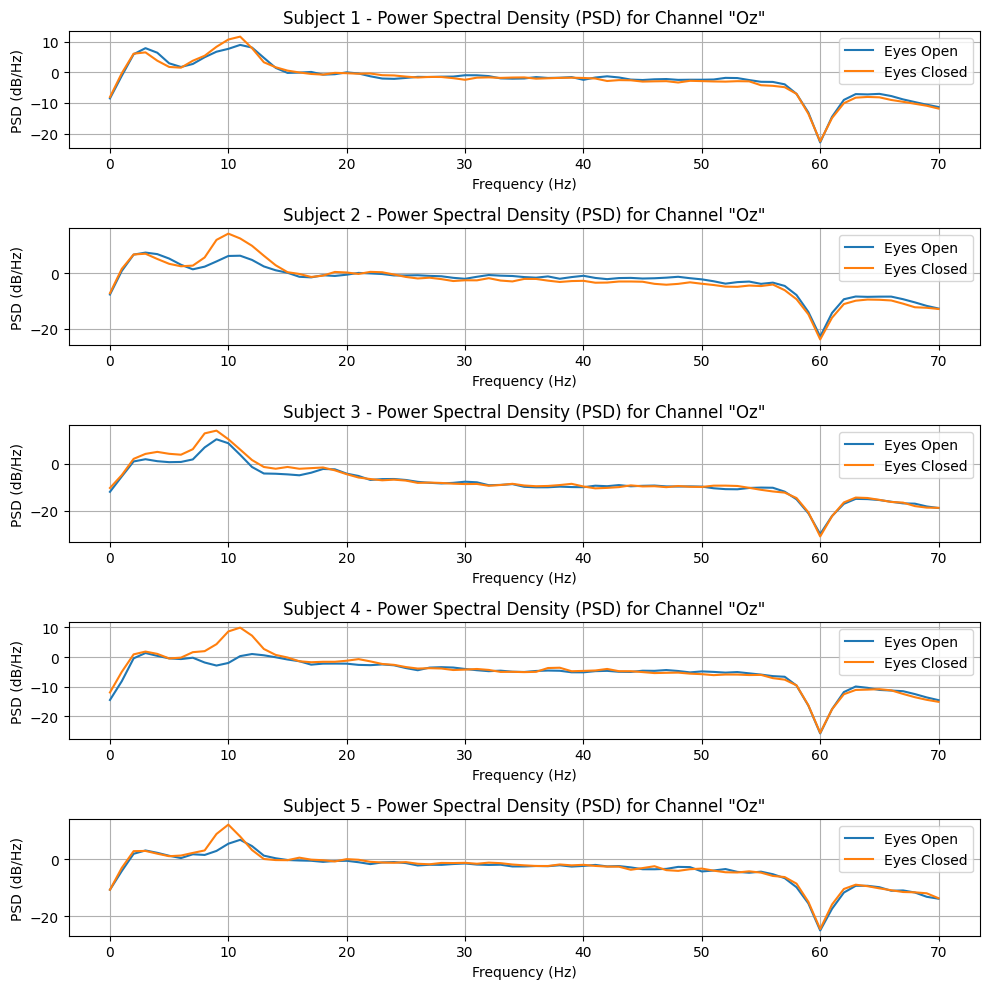

In [71]:
# a.
# Define the sampling frequency and parameters for the Welch method
fs = 256  # Given
nperseg = fs  #256 samples for a 1-second window
noverlap = nperseg // 2  # 50% overlap
# Compute PSD for each subject
frequencies, psd_open = welch(eyes_open_oz, fs=fs, nperseg=nperseg, noverlap=noverlap, axis=1)
_, psd_closed = welch(eyes_closed_oz, fs=fs, nperseg=nperseg, noverlap=noverlap, axis=1)
# Filtering the frequencies and corresponding PSD values to be within the 0-70 Hz range
mask = (frequencies >= 0) & (frequencies <= 70)
filtered_frequencies = frequencies[mask]
filtered_psd_open = psd_open[:, mask]
filtered_psd_closed = psd_closed[:, mask]
psd_open_log=10*np.log10(filtered_psd_open)
psd_closed_log=10*np.log10(filtered_psd_closed)
fig, axes = plt.subplots(n_s, 1, figsize=(10, 2*n_s))

for i in range(n_s):
    axes[i].plot(psd_open_log[i], label='Eyes Open')
    axes[i].plot(psd_closed_log[i], label='Eyes Closed')
    axes[i].set_title(f'Subject {i + 1} - Power Spectral Density (PSD) for Channel "Oz"')
    axes[i].set_xlabel('Frequency (Hz)')
    axes[i].set_ylabel('PSD (dB/Hz)')
    axes[i].legend()
    axes[i].grid(True, which='both')
plt.tight_layout()
plt.show()

In [95]:
alpha_mask = (filtered_frequencies >= 8) & (filtered_frequencies <= 12)
alpha_psd = psd_closed_log[:, alpha_mask]
peak_alpha_indices = np.argmax(alpha_psd, axis=1)
peak_alpha_frequencies = filtered_frequencies[alpha_mask][peak_alpha_indices]